# Melanoma Detection

## Problem Statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis

## Given Data Information

The dataset consists images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Import Libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import load_img
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import seaborn as sns
import glob as glob

### Data Reading / Data Understanding

I have dowloaded the data in my personal google drive and unzipped the same.

Step 1: Mounting google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Step 2: Defining the path for train and test images


In [4]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Step 3: Printing the count of images in each directory

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Count of Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Count of Test images:\t", image_count_test)

Count of Train images:	 2168
Count of Test images:	 115


### Dataset Creation

Step 1: Define some parameters for the loader

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Step 2: Let's load these images off disk using the helpful image_dataset_from_directory utility. Use 80% of the images for training, and 20% for validation.


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2168 files belonging to 9 classes.
Using 1735 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2168 files belonging to 9 classes.
Using 433 files for validation.



**Notes**:
- seed=123 is used while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
- images have been resized to 180*180, while writting the dataset

### Dataset visualisation

List out all the classes of skin cancer and store them in a list

In [11]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


one instance of all the nine classes present in the dataset

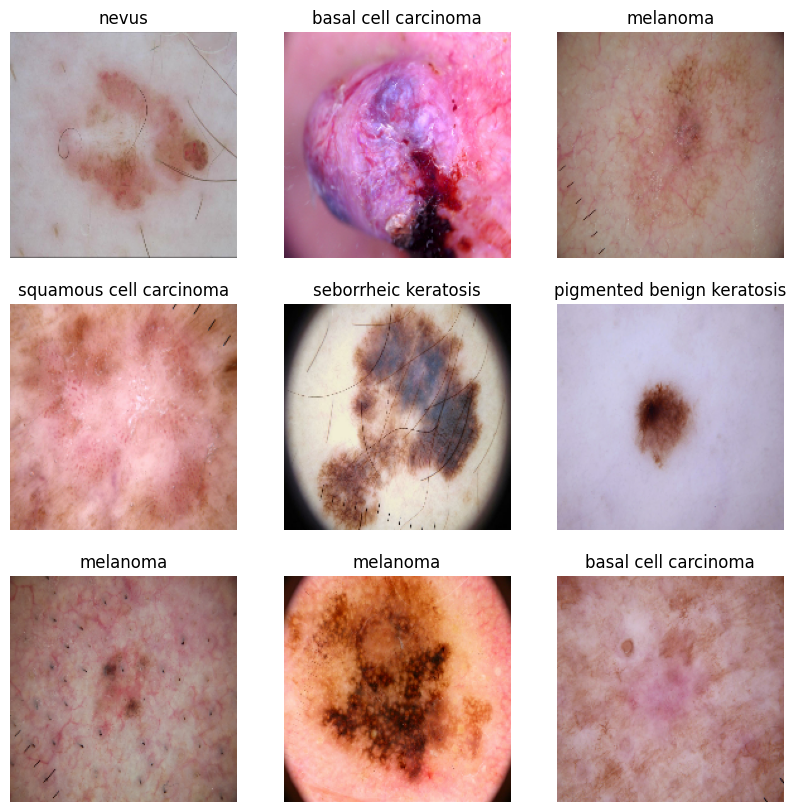

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.



Find the distribution of classes in the training dataset

In [15]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2168

In [17]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma


In [18]:
original_df.Label.value_counts()

pigmented benign keratosis    464
melanoma                      413
nevus                         358
basal cell carcinoma          325
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             113
dermatofibroma                 98
seborrheic keratosis           77
Name: Label, dtype: int64

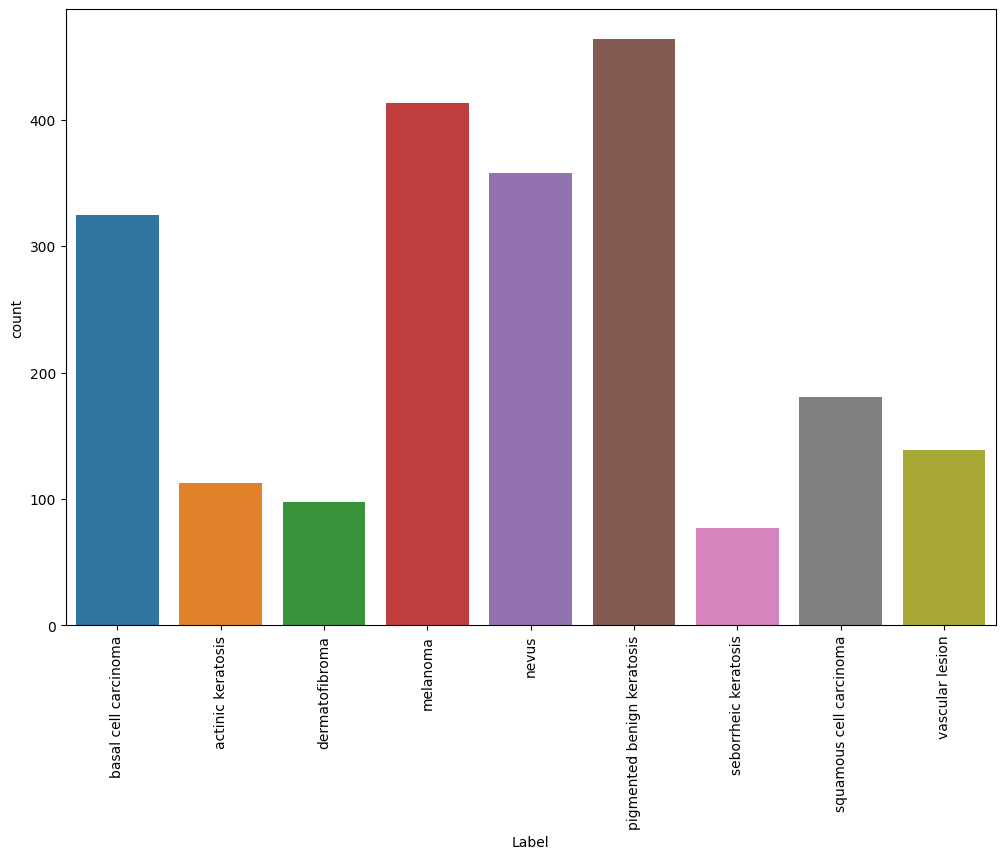

In [26]:
plt.figure(figsize=(12, 8))
sns.countplot(data=original_df, x='Label')
plt.xticks(rotation=90)
plt.show()

Insights:

- By looking at the count. There is clearly a class imbalance in the data set.
- actinic keratosis, dermatofibroma and seborrheic keratosis counts are near 100.
- melanoma and pigmented benign keratosis counts are above 400.

### Autotuning

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Building & Training

Step 1: Create Model

In [28]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Step 2: Compile the model

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Step 3: Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
55/55 [==============================] - 323s 3s/step - loss: 1.9759 - accuracy: 0.2853 - val_loss: 1.7134 - val_accuracy: 0.3626
Epoch 2/20
55/55 [==============================] - 64s 1s/step - loss: 1.6200 - accuracy: 0.4207 - val_loss: 1.5394 - val_accuracy: 0.4550
Epoch 3/20
55/55 [==============================] - 62s 1s/step - loss: 1.4675 - accuracy: 0.4997 - val_loss: 1.5614 - val_accuracy: 0.4642
Epoch 4/20
55/55 [==============================] - 65s 1s/step - loss: 1.3669 - accuracy: 0.5159 - val_loss: 1.3494 - val_accuracy: 0.5520
Epoch 5/20
55/55 [==============================] - 61s 1s/step - loss: 1.2243 - accuracy: 0.5695 - val_loss: 1.3964 - val_accuracy: 0.5058
Epoch 6/20
55/55 [==============================] - 64s 1s/step - loss: 1.1004 - accuracy: 0.6190 - val_loss: 1.3664 - val_accuracy: 0.5104
Epoch 7/20
55/55 [==============================] - 64s 1s/step - loss: 1.2038 - accuracy: 0.5775 - val_loss: 1.3860 - val_accuracy: 0.5381
Epoch 8/20
55/55 [=

Step 4: Visualize training result

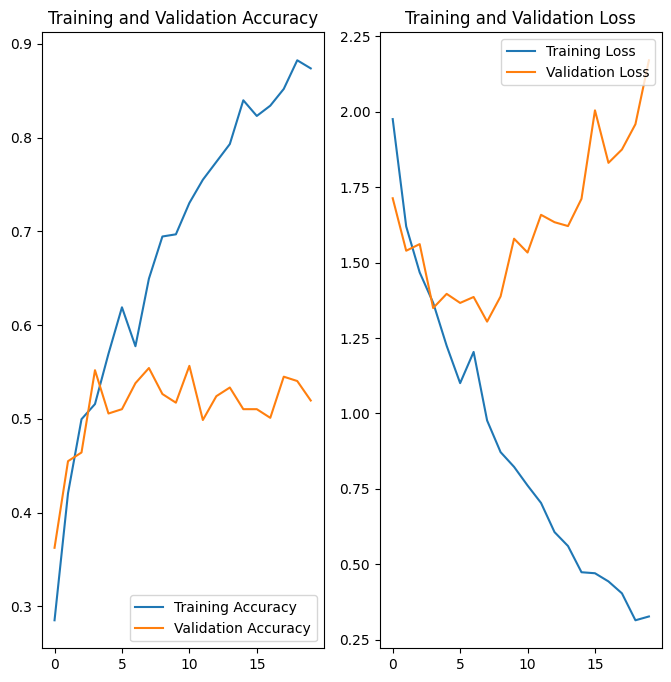

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls between 50% and 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

### Augmentation

Chose an appropriate data augmentation strategy to resolve overfitting

Step 1:

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Step 2: visualize how your augmentation strategy works for one instance of training image.

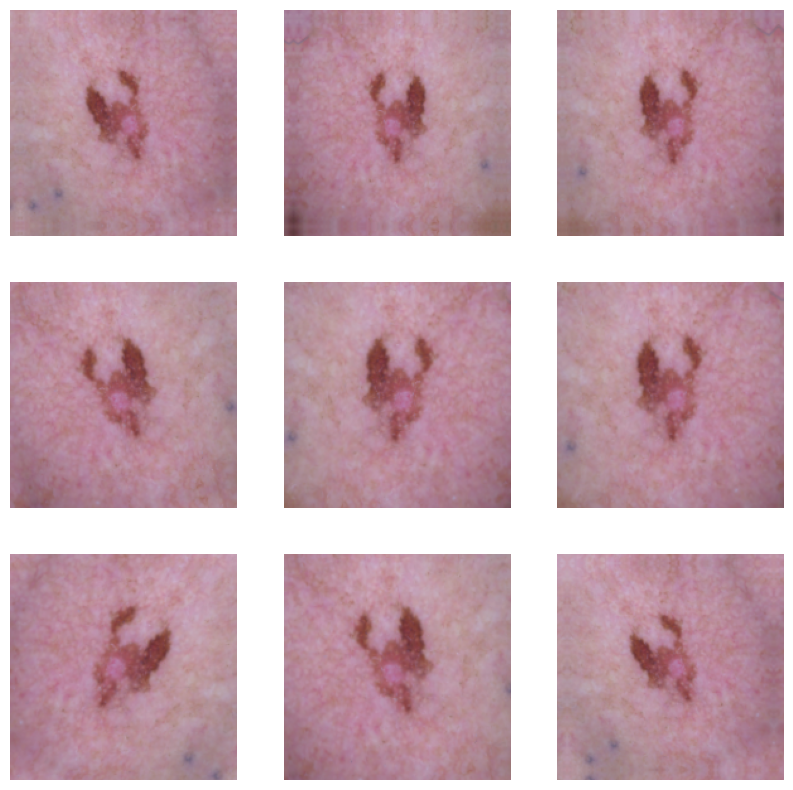

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building & training on the augmented data

I will follow all the steps again under Model Building and Training. Extra dropout layer has been introduced since there is overfitting.

In [36]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
55/55 [==============================] - 85s 1s/step - loss: 2.0702 - accuracy: 0.2432 - val_loss: 1.7724 - val_accuracy: 0.3834
Epoch 2/20
55/55 [==============================] - 78s 1s/step - loss: 1.7074 - accuracy: 0.3914 - val_loss: 1.5909 - val_accuracy: 0.4226
Epoch 3/20
55/55 [==============================] - 80s 1s/step - loss: 1.6369 - accuracy: 0.3994 - val_loss: 1.5380 - val_accuracy: 0.4434
Epoch 4/20
55/55 [==============================] - 74s 1s/step - loss: 1.5290 - accuracy: 0.4622 - val_loss: 1.5479 - val_accuracy: 0.4550
Epoch 5/20
55/55 [==============================] - 73s 1s/step - loss: 1.4433 - accuracy: 0.4997 - val_loss: 1.4310 - val_accuracy: 0.4942
Epoch 6/20
55/55 [==============================] - 78s 1s/step - loss: 1.3859 - accuracy: 0.5061 - val_loss: 1.3568 - val_accuracy: 0.5266
Epoch 7/20
55/55 [==============================] - 78s 1s/step - loss: 1.3249 - accuracy: 0.5360 - val_loss: 1.3812 - val_accuracy: 0.4758
Epoch 8/20
55/55 [==

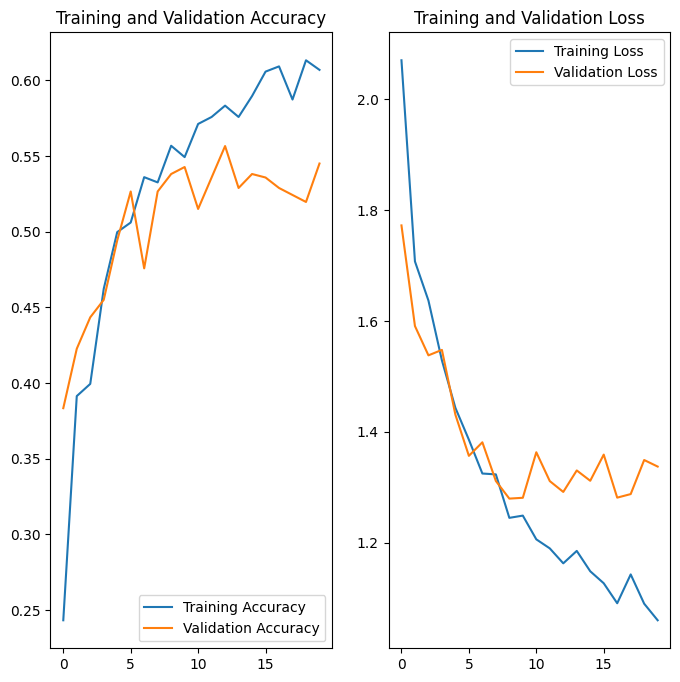

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Insights: Training accuracy is ~60% and Validation accuracy id ~54%. which is great for detection. However the problem of overfitting have almost gone.

### Class Distrubution

Find the distribution of classes in the training dataset

In [40]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2168

In [41]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,basal cell carcinoma


Class=1, n=325 (14.991%)
Class=0, n=113 (5.212%)
Class=2, n=98 (4.520%)
Class=3, n=413 (19.050%)
Class=4, n=358 (16.513%)
Class=5, n=464 (21.402%)
Class=6, n=77 (3.552%)
Class=7, n=181 (8.349%)
Class=8, n=139 (6.411%)


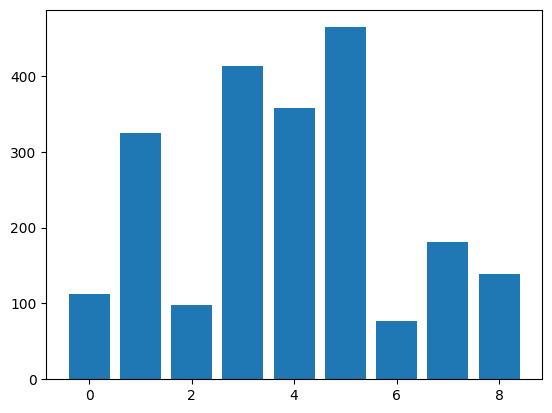

In [42]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

There is clear class imbalance exists in data. Next step is handle the class imbalance.

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data

### Handling Class Imbalances

We will use Augmentor Library for the same.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [43]:
# Installing Augmentor Library
!pip install Augmentor

In [44]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 113 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC858757FD0>: 100%|██████████| 500/500 [00:25<00:00, 19.43 Samples/s]


Initialised with 325 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC85872BB50>: 100%|██████████| 500/500 [00:26<00:00, 18.97 Samples/s]


Initialised with 98 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC85CFA53C0>: 100%|██████████| 500/500 [00:21<00:00, 22.95 Samples/s]


Initialised with 413 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AC8587725C0>: 100%|██████████| 500/500 [01:47<00:00,  4.65 Samples/s]


Initialised with 358 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7AC858757580>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 464 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC85987A9E0>: 100%|██████████| 500/500 [00:21<00:00, 22.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AC858772920>: 100%|██████████| 500/500 [00:48<00:00, 10.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC8587DE200>: 100%|██████████| 500/500 [00:22<00:00, 22.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC85887E500>: 100%|██████████| 500/500 [00:25<00:00, 19.33 Samples/s]


In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)
# 500 sample per class = 500 * 9 = 4500

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

Adding df2 with original data frame

In [47]:
new_df = original_df.append(df2)

<ipython-input-47-2ade1842133b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [48]:
new_df.Label.value_counts()

pigmented benign keratosis    964
melanoma                      913
nevus                         858
basal cell carcinoma          825
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             613
dermatofibroma                598
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

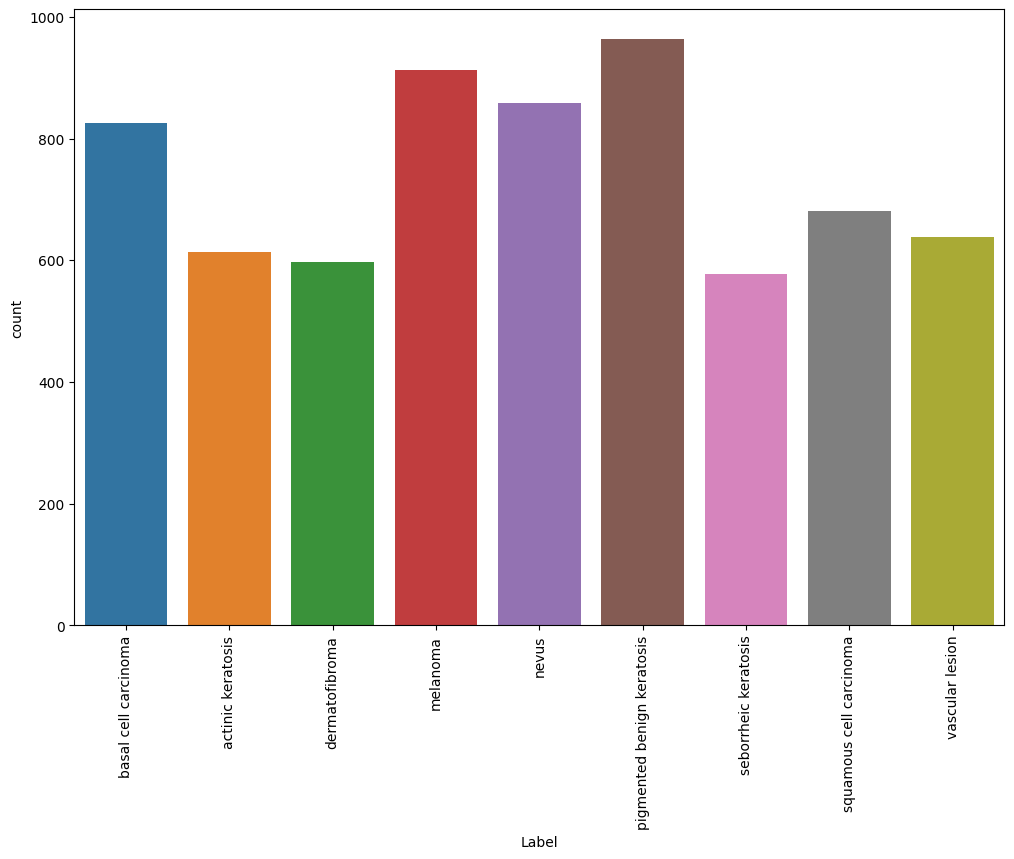

In [49]:
plt.figure(figsize=(12, 8))
sns.countplot(data=new_df, x='Label')
plt.xticks(rotation=90)
plt.show()

### Model Building & Training on the Rectified Class Imbalance Data

Step 1: Dataset creation

In [50]:
# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6668 files belonging to 9 classes.
Using 5335 files for training.


In [51]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6668 files belonging to 9 classes.
Using 1333 files for validation.


Step 2: Autotuning

In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Step 3: Model Creation

In [53]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Step 4: Model compilation

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Step 5: Model Training

In [55]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
167/167 [==============================] - 243s 1s/step - loss: 1.8617 - accuracy: 0.2791 - val_loss: 1.7715 - val_accuracy: 0.3166
Epoch 2/20
167/167 [==============================] - 215s 1s/step - loss: 1.4638 - accuracy: 0.4470 - val_loss: 1.3810 - val_accuracy: 0.5064
Epoch 3/20
167/167 [==============================] - 202s 1s/step - loss: 1.2318 - accuracy: 0.5528 - val_loss: 1.1953 - val_accuracy: 0.5829
Epoch 4/20
167/167 [==============================] - 207s 1s/step - loss: 1.0615 - accuracy: 0.6178 - val_loss: 1.0830 - val_accuracy: 0.6077
Epoch 5/20
167/167 [==============================] - 201s 1s/step - loss: 0.9118 - accuracy: 0.6720 - val_loss: 0.9696 - val_accuracy: 0.6542
Epoch 6/20
167/167 [==============================] - 202s 1s/step - loss: 0.7739 - accuracy: 0.7245 - val_loss: 0.8790 - val_accuracy: 0.6797
Epoch 7/20
167/167 [==============================] - 199s 1s/step - loss: 0.6686 - accuracy: 0.7663 - val_loss: 0.8331 - val_accuracy: 0.6947

### Analysis

- First Model (Simple Model): Training Accuracy: 88%, Validation Accuracy: 52%
- Second Model (With Augmentation): Training Accuracy: 61%, Validation Accuracy: 55%
- Third Model (With Augmentor Library): Training Accuracy: 92%, Validation Accuracy: 83%

    Insights:
    - There is still some differences in accuracy. i.e. model is still slightly overfit but better than previous models
    - Model after handling class imbalance performs better.